IMPORT LIBRARIES

In [2]:
# Import libraries
import os
import librosa
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import sounddevice as sd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from random import shuffle
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


TASK 1: Read wav files and create numpy array of them

    TASK 1.1 Get voiced parts

In [5]:
#Get autocorrelation coefficients
def get_auto_correlation(clip, FRAME_SIZE = 100):
    bins = np.zeros(FRAME_SIZE)
    for i in range(0, FRAME_SIZE):
        for j in range(0, FRAME_SIZE-i):
            bins[i] += (clip[j] * clip[j+i])
    return bins

#Using autocorrelation coefficients and RMS to get voiced parts
def get_voiced_parts(clip, sr, FRAME_SIZE = 100):
    IS_CURR_VOICED = False

    MAX_NUM_FRAMES = 25
    START_NUM_FRAMES = 20
    MIN_NUM_OF_SAMPLES_IN_SEGMENT = 0.2 * sr
    MIN_RMS = 0.05

    voiced_counter = 0
    start_of_segment = -1
    end_of_segment = -1
    end_of_checking = (len(clip)//FRAME_SIZE-1) * FRAME_SIZE

    for i in range(0, end_of_checking, FRAME_SIZE):
        #for each frame
        bins = np.zeros(FRAME_SIZE)
        bins = get_auto_correlation(clip[i:i+FRAME_SIZE], FRAME_SIZE)
        maximums = np.diff(argrelextrema(bins, np.greater))
        median_maximums = np.median(maximums)
        #if median maximus in some boudaries
        if median_maximums >= 7 and median_maximums <= 20 and np.std(maximums) < 7:
            voiced_counter = min(voiced_counter + 1, MAX_NUM_FRAMES)

            if not IS_CURR_VOICED:
                voiced_counter = START_NUM_FRAMES
                IS_CURR_VOICED = True
                start_of_segment = i
        else:
            voiced_counter = max(0, voiced_counter - 1)

            if voiced_counter == 0 and IS_CURR_VOICED:
                IS_CURR_VOICED = False
                end_of_segment = i
                #if too short
                if end_of_segment - start_of_segment < MIN_NUM_OF_SAMPLES_IN_SEGMENT:
                    continue 
                rms = np.sqrt(np.mean(clip[start_of_segment:end_of_segment]**2))
                if rms < MIN_RMS:
                    continue
                return clip[start_of_segment: end_of_segment]

    end_of_segment = len(clip)
    
    if IS_CURR_VOICED and ((end_of_segment - start_of_segment) > MIN_NUM_OF_SAMPLES_IN_SEGMENT):
        return clip[start_of_segment: end_of_segment]       
    return None

    

VIZUALIZATION

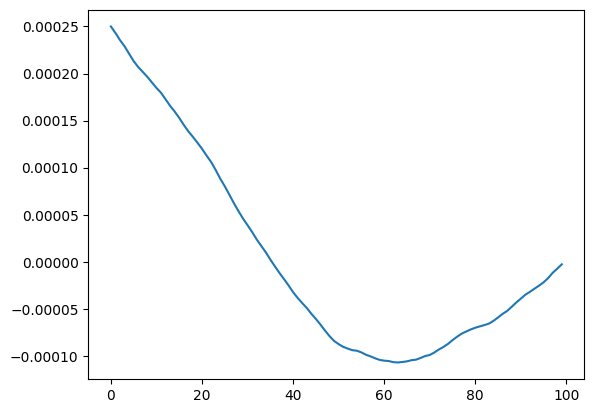

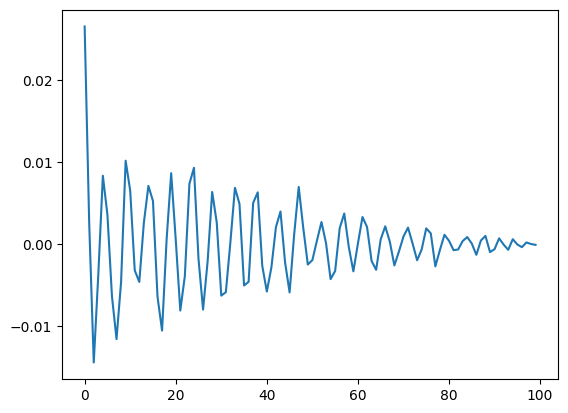

In [7]:

new_sr = 8000
clip, sr = librosa.load("../data/six/anja_3.wav")
clip = librosa.resample(clip, orig_sr=sr, target_sr=new_sr)
clip = librosa.to_mono(clip)
clip = librosa.util.normalize(clip)

plt.plot(get_auto_correlation(clip[:100]))
plt.show()
plt.plot(get_auto_correlation(clip[8000:8100]))

TESTING !!!!

d:\Anaconda\envs\IASR\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda\envs\IASR\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.4875 1.0125


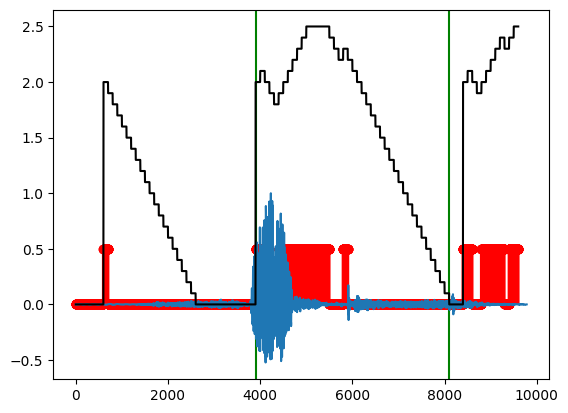

In [8]:
#Vizualization to tune algorithm for getting voiced parts
new_sr = 8000
clip, sr = librosa.load("../data/six/anja_3.wav")
clip = librosa.resample(clip, orig_sr=sr, target_sr=new_sr)
clip = librosa.to_mono(clip)
clip = librosa.util.normalize(clip)

IS_CURR_VOICED = False

MAX_NUM_FRAMES = 25
START_NUM_FRAMES = 20
MIN_NUM_OF_SAMPLES_IN_SEGMENT = 0.2 * new_sr
MIN_RMS = 0.05

voiced_counter = 0
start_of_segment = -1
end_of_segment = -1
FRAME_SIZE = 100
len_clip_in_frames = len(clip) // FRAME_SIZE - 1
end_of_checking = len_clip_in_frames * FRAME_SIZE
out = np.zeros(len_clip_in_frames)
curr_voiced_over_time = np.zeros(len_clip_in_frames)

for i in range(0, end_of_checking, FRAME_SIZE):
    #for each frame
    bins = np.zeros(FRAME_SIZE)
    bins = get_auto_correlation(clip[i:i+FRAME_SIZE], FRAME_SIZE)
    #plt.stem(bins)
    maximums = np.diff(argrelextrema(bins, np.greater))
    median_maximums = np.median(maximums)
    #if median maximus in some boudaries
    if median_maximums >= 7 and median_maximums <= 20 and np.std(maximums) < 7:
        out[i//FRAME_SIZE] = 1
        voiced_counter = min(voiced_counter + 1,MAX_NUM_FRAMES)
        if  not IS_CURR_VOICED:
            voiced_counter = START_NUM_FRAMES
            IS_CURR_VOICED = True
            start_of_segment = i
    else:
        voiced_counter = max(0, voiced_counter-1)

        if voiced_counter == 0 and IS_CURR_VOICED:
            IS_CURR_VOICED = False
            end_of_segment = i
            #if too short
            if end_of_segment - start_of_segment < MIN_NUM_OF_SAMPLES_IN_SEGMENT:
                continue

            rms = np.sqrt(np.mean(clip[start_of_segment:end_of_segment]**2))
            if rms < MIN_RMS:
                continue

            a = clip[start_of_segment: end_of_segment]
            print(start_of_segment/new_sr, end_of_segment/new_sr)
            plt.axvline(start_of_segment, color='g')
            plt.axvline(end_of_segment, color='g')

    #plt.show() 

    curr_voiced_over_time[i//FRAME_SIZE] = voiced_counter
end_of_segment = len(clip)
if IS_CURR_VOICED and ((end_of_segment - start_of_segment) > MIN_NUM_OF_SAMPLES_IN_SEGMENT):
    plt.axvline(start_of_segment, color='g')
    plt.axvline(end_of_segment, color='g')
    print(end_of_segment - start_of_segment)
#print(start_of_segment/new_sr, end_of_segment/new_sr)
plt.stem(np.repeat(out, FRAME_SIZE)*0.5, 'r')
plt.plot(clip)

plt.plot(np.repeat(curr_voiced_over_time, FRAME_SIZE)*0.1, 'k')
sd.play(a, 8000)
#print(maximums)
#plt.plot(clip)

    TASK 1.2 Normalize between -1 and 1

TASK 2. FEATURE EXTRACTION

    TASK 2.1 Preemphasis filter

In [9]:
def add_preemphasis_filter(x, coeff=0.95):
    x = librosa.effects.preemphasis(x, coef = coeff)
    return x

    TASK 2.2 Create MFCC of samles of uniform size (30, 80)

In [10]:
def get_2d_features(y, sr = 8000, wanted_width = 40):
    y = add_preemphasis_filter(y)
    #20 row mfcc, 20 row delta mfcc, 1 row pitch...
    windows_size = len(y) // (wanted_width - 1)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mels=20, n_fft=300, hop_length=windows_size, window='hamming')
    delta_mfcc = librosa.feature.delta(mfcc)
    mfcc = np.concatenate((mfcc, delta_mfcc, ), axis=0)
    return mfcc

In [11]:
def get_1d_features(y, sr = 8000, wanted_width = 15):
    windows_size = len(y)//(wanted_width - 1)
    #coeffients of polynomial fitting frequency information over time
    polly_coeff = librosa.feature.poly_features(y=y, sr=sr, order=0, n_fft=1024, hop_length=windows_size, window='hamming')[0]
    #how many times do signal cross zero
    zero_cross = librosa.feature.zero_crossing_rate(y=y, frame_length=1024, hop_length=windows_size)[0]
    #tone vs noise level in each windows
    tone_vs_noise = librosa.feature.spectral_flatness(y=y, n_fft=1024, hop_length=windows_size)[0]
    
    return np.concatenate((polly_coeff, zero_cross, tone_vs_noise), axis=0)

        TESTING!

[1.96106228 2.47820786 2.84961828 2.89422679 2.47651209 1.79976383
 1.25501828 0.66353464 0.25662492 0.07763222 0.03944047 0.22429256
 0.56750403 0.62614029 0.32693331 0.22558594 0.33203125 0.43847656
 0.49609375 0.50683594 0.515625   0.51367188 0.52636719 0.53515625
 0.55273438 0.58691406 0.59960938 0.55371094 0.43164062 0.30664062
 0.14811702 0.07132981 0.04584308 0.03867511 0.03035369 0.02013501
 0.02568689 0.0409455  0.06822983 0.1529315  0.21928482 0.33346218
 0.32430181 0.34581098 0.31616148]


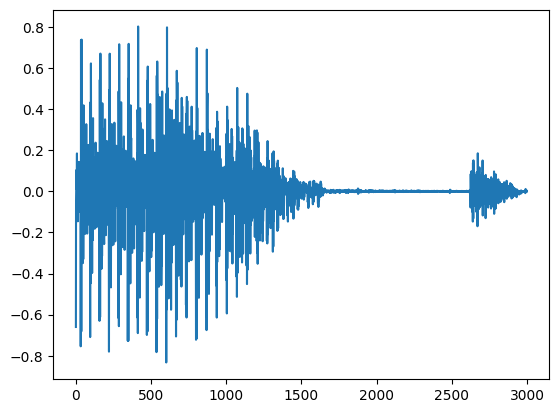

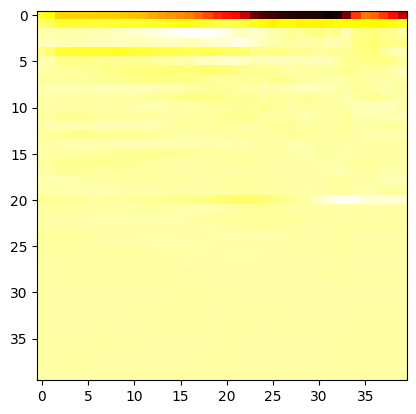

In [12]:
#see features
new_sr = 8000
clip, sr = librosa.load("../data/eight/luka_3.wav")
clip = librosa.resample(clip, orig_sr=sr, target_sr=new_sr)
clip = librosa.to_mono(clip)
clip = librosa.util.normalize(clip)
clip = get_voiced_parts(clip, new_sr)
clip = add_preemphasis_filter(clip)
features = get_2d_features(clip, new_sr)


print(get_1d_features(clip))

sd.play(clip, new_sr)
sd.wait()
plt.plot(clip)
plt.show()
plt.imshow(features, cmap='hot', interpolation='nearest')

    TASK 2.3 Other feutures -TODO

Here we see the example main function to create train/validate and test set

In [159]:
def make_train_data(directory):
    training_data = []
    labels = []
    eye_in = 0
    NUM_SAMPLES_PER_CATEGORY = 400 #maximum ammiount of data in library
    NUM_CATEGORIES = len(os.listdir(directory))
    #get all subdirectories in directory
    for category in os.listdir(directory):
        #if we have skiped some categories (hidden symbol .)
        if category[0] == '.':
            print("skipping {}".format(category))
            continue
        print(category)
        labels.append(category)
        path = os.path.join(directory, category)

        files = os.listdir(path)
        #shuffle to get random data 
        shuffle(files)
        #we have less data on operators so we limit the ammmount of data we can use
        files = files[1:NUM_SAMPLES_PER_CATEGORY]

        for file in files:
            try:
                #Fs, audio = wavfile.read(os.path.join(path, file))
                clip, sr = librosa.load(os.path.join(path, file))
                clip = librosa.resample(clip, orig_sr=sr, target_sr=8000)
                clip = librosa.to_mono(clip)

                clip = librosa.util.normalize(clip)
                clip = get_voiced_parts(clip,8000)

                if(clip is None):
                    #if a voiced part is not found
                    print("{} not good".format(os.path.join(path, file)))
                    continue

                features_2d = get_2d_features(clip)
                features_1d = get_1d_features(clip)

                training_data.append([features_2d, features_1d, np.eye(NUM_CATEGORIES)[eye_in]])
            except Exception as e:
                print(e)
                pass
        #get next one hot label
        eye_in += 1
    #shuffle data
    np.random.shuffle(training_data)
    training_data = np.array(training_data, dtype=object)

    # Split the features and labels
    X_2d = np.array([i[0] for i in training_data])
    X_1d = np.array([i[1] for i in training_data])
    y = np.array([i[2] for i in training_data])

    # Split the data into training and test sets
    X_2d_train, X_2d_test, X_1d_train, X_1d_test, y_train, y_test = train_test_split(X_2d, X_1d, y, test_size=0.15, random_state=42)

    return np.array(labels), X_2d_train, X_2d_test, X_1d_train, X_1d_test, y_train, y_test

Train all data

In [160]:
labels, X_2d_train, X_2d_test, X_1d_train, X_1d_test, y_train, y_test = make_train_data(os.path.join(os.getcwd(), "..", "data"))

np.savez("training_data_more.npz", labels=labels, X_2d_train=X_2d_train, X_2d_test=X_2d_test, X_1d_train=X_1d_train, X_1d_test=X_1d_test, y_train=y_train, y_test=y_test)

eight
d:\Faks\5\ERASMUS\ImageAndSpeechRecognition\Project\IASRProject\model\src\..\data\eight\8_george_27.wav not good


d:\Anaconda\envs\IASR\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda\envs\IASR\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


d:\Faks\5\ERASMUS\ImageAndSpeechRecognition\Project\IASRProject\model\src\..\data\eight\yweweler_42.wav not good
d:\Faks\5\ERASMUS\ImageAndSpeechRecognition\Project\IASRProject\model\src\..\data\eight\8_george_42.wav not good
d:\Faks\5\ERASMUS\ImageAndSpeechRecognition\Project\IASRProject\model\src\..\data\eight\8_george_35.wav not good
d:\Faks\5\ERASMUS\ImageAndSpeechRecognition\Project\IASRProject\model\src\..\data\eight\8_lucas_36.wav not good
d:\Faks\5\ERASMUS\ImageAndSpeechRecognition\Project\IASRProject\model\src\..\data\eight\8_george_26.wav not good
d:\Faks\5\ERASMUS\ImageAndSpeechRecognition\Project\IASRProject\model\src\..\data\eight\aditya_3.wav not good
d:\Faks\5\ERASMUS\ImageAndSpeechRecognition\Project\IASRProject\model\src\..\data\eight\aditya_5.wav not good
d:\Faks\5\ERASMUS\ImageAndSpeechRecognition\Project\IASRProject\model\src\..\data\eight\8_george_22.wav not good
d:\Faks\5\ERASMUS\ImageAndSpeechRecognition\Project\IASRProject\model\src\..\data\eight\8_lucas_1.wav n

Task 3. Neural network

In [16]:
#Load whole set
labels, X_2d_train, X_2d_test, X_1d_train,  X_1d_test, y_train,y_test = np.load("training_data_more.npz", allow_pickle=True).values()

In [17]:
#see the loaded data
print(y_train.shape)
print(X_2d_train.shape)
print(X_1d_train.shape)

print(y_test.shape)
print(X_2d_test.shape)
print(X_1d_test.shape)
print(labels)
print(len(labels))

(3056, 14)
(3056, 40, 40)
(3056, 45)
(540, 14)
(540, 40, 40)
(540, 45)
['eight' 'five' 'four' 'minus' 'nine' 'one' 'over' 'plus' 'seven' 'six'
 'three' 'times' 'two' 'zero']
14


In [18]:
#see the number of trainiing samples for each category
a, b = np.unique(y_train, return_counts=True,axis=0)
for i in range(len(a)):
    print(labels[np.argmax(a[i], axis = 0)], b[i])

zero 285
two 173
times 127
three 213
six 219
seven 272
plus 134
over 143
one 280
nine 265
minus 138
four 277
five 274
eight 256


 Example show of random feature vector

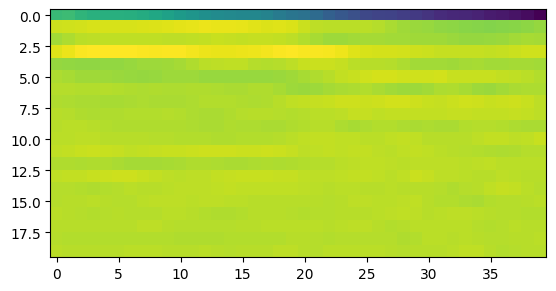

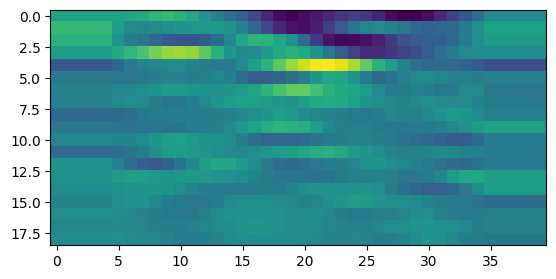

C:\Users\38631\AppData\Local\Temp\ipykernel_18212\1905626958.py:14: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(X_2d_train[INDEX]))


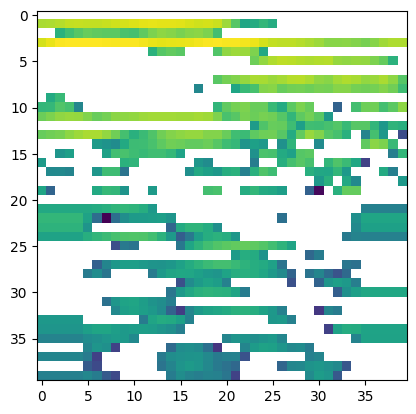

[2.28891596e+00 2.75281740e+00 2.65718923e+00 2.18611065e+00
 1.58866024e+00 1.10559413e+00 7.60133285e-01 5.13160543e-01
 2.99314824e-01 1.49671146e-01 7.55667040e-02 4.74402179e-02
 3.22677565e-02 2.26010570e-02 1.46768507e-02 4.78515625e-02
 5.95703125e-02 7.12890625e-02 8.10546875e-02 8.20312500e-02
 8.49609375e-02 7.32421875e-02 8.30078125e-02 1.25976562e-01
 1.70898438e-01 2.27539062e-01 2.57812500e-01 2.50976562e-01
 2.39257812e-01 2.05078125e-01 2.98166834e-02 1.71930622e-02
 8.74844100e-03 4.19859914e-03 2.45699915e-03 1.91503542e-03
 1.99800078e-03 2.77872197e-03 4.07311274e-03 6.64222008e-03
 1.12848775e-02 3.44035923e-02 1.00157529e-01 1.44715071e-01
 1.52130604e-01]
three


In [19]:
# Features from mfcc
## Index of sample to observe
INDEX = 2

## MFCC features
plt.imshow(X_2d_train[INDEX][:20])
plt.show()

## Delta MFCC features
plt.imshow(X_2d_train[INDEX][21:])
plt.show()

## Logarithmic MFCC features
plt.imshow(np.log10(X_2d_train[INDEX]))
plt.show()
print(X_1d_train[INDEX])
print(labels[np.argmax(y_test[INDEX])])

In [20]:
# Define the missing variables
height = 40
width = 40
number_of_linear_values = 45 #we expect 3*15=24 additional linear values
number_of_classes = len(labels)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #we have 4 convolutional layers with 3x3 kernels
        self.conv1 = nn.Conv2d(1, 20, 3, padding=1)
        self.conv2 = nn.Conv2d(20, 30, 3, padding=1)
        self.conv3 = nn.Conv2d(30, 40, 3, padding=1)
        self.conv4 = nn.Conv2d(40, 50, 3, padding=1)

        #We normalize each layer, we have found much better results with this
        self.conv1_bn = nn.BatchNorm2d(1)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.conv3_bn = nn.BatchNorm2d(30)
        self.conv4_bn = nn.BatchNorm2d(40)
        #dropout layer to reduce overfitting
        self.dropoutcovn1 = nn.Dropout(0.1)

        #to calculate the size of the input to the linear layers
        x = torch.randn(height,width).view(-1,1,height,width)
        self._to_linear = None
        self.convs(x)

        #we have 3 linear layers - input is flattened convolutional layers and additional linear values
        self.fc1 = nn.Linear(self._to_linear + number_of_linear_values, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, number_of_classes) # Adjusted to match the number of classes
        #we aslo have some dropout layers for fc1
        self.dropoutfc1 = nn.Dropout(0.1)
    def convs(self, x):
        #we dropout firstly and do max pooling after each convolutional layer
        x = self.dropoutcovn1(x)
        x = self.conv1_bn(x)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = self.conv2_bn(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = self.conv3_bn(x)
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = self.conv4_bn(x)
        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, data_2d, data_1d):
        data_2d = self.convs(data_2d)
        #now new data is added to linear layers
        data_2d = data_2d.view(-1, self._to_linear)
        #combine flattened features from convolutional layers and additional linear features
        x = torch.cat((data_2d , data_1d), dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropoutfc1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)


In [210]:
#we run on GPU (if can) - for training
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")
    
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'
net = Net().to(device)

GPU


In [21]:
#for testing only on CPU
device = torch.device("cpu")
net = Net().to(device)

In [211]:
#optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001)
#
err_f = nn.MSELoss()

#get data in right containers
train_2d_X = torch.Tensor(X_2d_train).view(-1, 40, 40)
train_1d_X = torch.Tensor(X_1d_train)
train_y = torch.Tensor(y_train)

In [337]:


# Get the height and width of the first image
height, width = train_2d_X.shape[1], train_2d_X.shape[2]

#training
BATCH_SIZE = 16
EPOH = 1
N = 1 #how ofter we print loss
EPSILON = 0.0001 #if loss different under this we stop - don't want to overtrain! We don't have much training data

running_loss = 0.0
all_losses = [100]
for epoch in range(EPOH):
    for i in range(0, len(train_2d_X), BATCH_SIZE):
        batch_X_2d = train_2d_X[i:i+BATCH_SIZE].view(-1,1,height,width).to(device)
        batch_X_1d = train_1d_X[i:i+BATCH_SIZE].to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        #batch_X_2d, batch_X_1d, batch_y = batch_X_2d.to(device), batch_X_1d.to(device), batch_y.to(device)

        net.zero_grad() #zero gradient
        #forward pass
        out = net(batch_X_2d, batch_X_1d)
        #error function
        err = err_f(out, batch_y)
        #propagate erroe
        err.backward()
        #optimize
        optimizer.step()
        
        running_loss += err.item()
    # Generate a random permutation of indices
    perm = torch.randperm(train_2d_X.size(0))
    # Use the permutation to shuffle the tensors
    train_2d_X = train_2d_X[perm]
    train_1d_X = train_1d_X[perm]
    train_y = train_y[perm]

    #printing output
    if epoch % N == N-1:
        print("EPOH {}/{} loss: {}".format(epoch+1, EPOH, running_loss/N))
        all_losses.insert(0, running_loss/N)
        if all_losses[1]-all_losses[0] < EPSILON: #less than percent impromvenet
            break
        running_loss = 0.0
    if epoch % 5 == 4:
        clear_output(wait=True)   

EPOH 1/1 loss: 0.39508067379755274


In [319]:
# Save the whole model
torch.save(net.state_dict(), 'model.pth')

###   Run the mode over training set

In [22]:
#load the model
net = Net().to(device)
net.load_state_dict(torch.load('model.pth'))
net.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(40, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_bn): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropoutcovn1): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=245, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=14, bias=True)
  (dropoutfc1): Dropout(p=0.1, inplace=False)
)

###                   Test on training data - testing for overfitting

0.01832460732984293


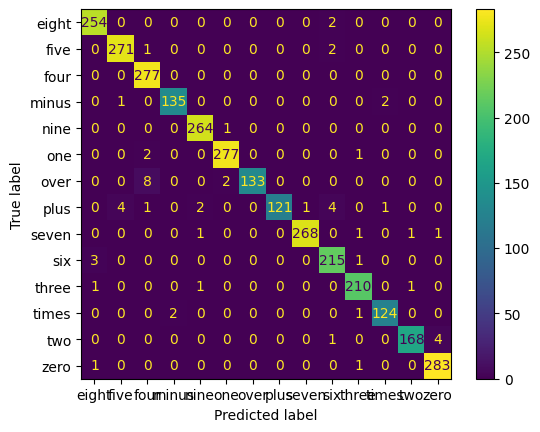

In [23]:
missclassified = 0
actual = []
predicted = []
net.eval()
with torch.no_grad():
    data_2d = torch.Tensor(X_2d_train).view(-1,1,height,width).to(device) #flatten
    data_1d = torch.Tensor(X_1d_train).to(device)
    #data_2d = data_2d.view(-1,1,height,width)
    output = net(data_2d, data_1d).to(device).cpu()

    for i in range(output.shape[0]):
        classification = torch.argmax(output[i])
        base_truth = np.argmax(y_train[i])
        predicted.append(classification)
        actual.append(base_truth)
        #print("{} ; {}".format(labels[base_truth], labels[classification]))
        if base_truth != classification:
            missclassified += 1

print(missclassified / y_train.shape[0])
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
cm_display.plot()
plt.show()

five ; five
five ; five
three ; three
five ; five
one ; one
nine ; nine
eight ; eight
one ; one
one ; one
zero ; zero
one ; one
one ; one
six ; six
seven ; seven
eight ; six
five ; five
three ; three
three ; three
nine ; nine
six ; six
four ; four
zero ; zero
two ; two
nine ; nine
nine ; nine
three ; three
two ; two
four ; four
five ; five
four ; four
seven ; seven
six ; six
five ; five
seven ; seven
three ; three
seven ; seven
eight ; eight
minus ; minus
nine ; nine
two ; two
eight ; eight
five ; five
seven ; seven
over ; over
seven ; seven
eight ; eight
two ; two
two ; two
times ; times
nine ; nine
eight ; eight
five ; five
three ; three
six ; six
eight ; eight
nine ; nine
four ; four
times ; times
one ; one
one ; one
seven ; seven
plus ; plus
six ; six
zero ; zero
five ; five
nine ; nine
times ; times
over ; over
three ; three
eight ; eight
plus ; plus
five ; five
plus ; plus
six ; six
one ; one
five ; five
four ; four
seven ; seven
eight ; eight
times ; times
five ; five
nine ; nin

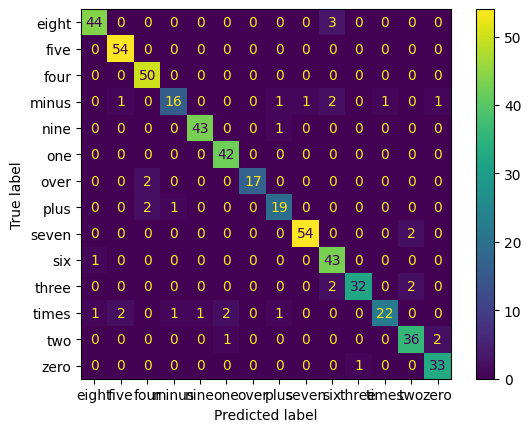

In [24]:
missclassified = 0
actual = []
predicted = []
net.eval()
with torch.no_grad():
    data_2d = torch.Tensor(X_2d_test).view(-1,1,height,width).to(device) #flatten
    data_1d = torch.Tensor(X_1d_test).to(device)
    #data_2d = data_2d.view(-1,1,height,width)
    output = net(data_2d, data_1d).to(device).cpu()

    for i in range(output.shape[0]):
        classification = torch.argmax(output[i])
        base_truth = np.argmax(y_test[i])
        predicted.append(classification)
        actual.append(base_truth)
        print("{} ; {}".format(labels[base_truth], labels[classification]))
        if base_truth != classification:
            missclassified += 1

print(missclassified / y_test.shape[0])
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
cm_display.plot()
plt.show()

# Record new data

In [343]:
import os
import sounddevice as sd
from scipy.io import wavfile 

freq = 44100
duration = 3

#testing on real data -saying into microphone
try:
    recording = sd.rec(int(duration * freq), samplerate=freq, channels=2)
    print("Recording: start speaking...")

    sd.wait()

    filepath = os.path.join(os.getcwd(), "..", "input", "input.wav")
    wavfile.write(filepath, freq, recording)  # Fix the function call

except Exception as e:
    print("An error occurred:", e)

Recording: start speaking...


    Example of classification pipeline

In [344]:
# Classify new data said in mike
net.eval()
with torch.no_grad():
    clip, sr = librosa.load(filepath)
    clip = librosa.resample(clip, orig_sr=sr, target_sr=8000)
    clip = librosa.to_mono(clip)
    clip = librosa.util.normalize(clip)
    clip = get_voiced_parts(clip,8000)
    clip = add_preemphasis_filter(clip)
    features_2d = get_2d_features(clip, 8000)
    features_2d = torch.Tensor(features_2d).view(-1,1,40,40).to(device)
    features_1d = torch.Tensor(get_1d_features(clip, 8000))
    features_1d = torch.unsqueeze(features_1d, dim = 0).to(device) #change the shape of the tensor
    out = net(features_2d, features_1d)
    classification = torch.argmax(out)

    out = out[0].detach().cpu().numpy()
    debug_ind = out.argsort()[::-1].astype('int')
    #print 3 most probable solutions
print("{}; {}".format(np.array(labels)[debug_ind][:3], np.around(out[debug_ind][:3], decimals=3)))

['three' 'six' 'eight']; [0.827 0.169 0.003]


In [342]:
#hear the snipped clip to vizualy check
sd.play(clip,8000)
sd.wait()